In [14]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Lambda
from keras import Input, Model
from keras import backend as K
from keras.regularizers import l2
from keras.utils import plot_model
from keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
import pickle
import time

In [15]:
# Check whether GPU is being or not
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17072656559044599414
]


### Looking at Dataset

In [ ]:
alphabet = os.listdir('images_background')

In [ ]:
alphabet

['Alphabet_of_the_Magi',
 'Anglo-Saxon_Futhorc',
 'Arcadian',
 'Armenian',
 'Asomtavruli_(Georgian)',
 'Balinese',
 'Bengali',
 'Blackfoot_(Canadian_Aboriginal_Syllabics)',
 'Braille',
 'Burmese_(Myanmar)',
 'Cyrillic',
 'Early_Aramaic',
 'Futurama',
 'Grantha',
 'Greek',
 'Gujarati',
 'Hebrew',
 'Inuktitut_(Canadian_Aboriginal_Syllabics)',
 'Japanese_(hiragana)',
 'Japanese_(katakana)',
 'Korean',
 'Latin',
 'Malay_(Jawi_-_Arabic)',
 'Mkhedruli_(Georgian)',
 'N_Ko',
 'Ojibwe_(Canadian_Aboriginal_Syllabics)',
 'Sanskrit',
 'Syriac_(Estrangelo)',
 'Tagalog',
 'Tifinagh']

In [ ]:
os.listdir('images_background/Alphabet_of_the_Magi')

['character01',
 'character02',
 'character03',
 'character04',
 'character05',
 'character06',
 'character07',
 'character08',
 'character09',
 'character10',
 'character11',
 'character12',
 'character13',
 'character14',
 'character15',
 'character16',
 'character17',
 'character18',
 'character19',
 'character20']

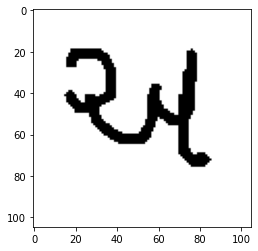

In [ ]:
plt.imshow(cv2.imread('images_background/Gujarati/character01/0418_01.png'))

### Loading Images into Tensors

In [16]:
def load_imgs(path, n=0):
    '''
    path ==> path to images directory
    
    '''
    char_dict = {}
    lang_dict = {}
    X = []
    y = []
    curr_y = n
    
    for alpha in os.listdir(path):
        print('loading alphabet', alpha)
        lang_dict[alpha] = [curr_y, None]   ### getting first and last index of a alpha ###
        alpha_path = os.path.join(path, alpha)
        
        for char in os.listdir(alpha_path):
            char_dict[curr_y] = (alpha, char) ### which index belongs to which char and alpha ###
            char_path = os.path.join(alpha_path, char)
            category_imgs = []
            
            for img in os.listdir(char_path):
                category_imgs.append(cv2.imread(os.path.join(char_path,img))) ### 1. getting path, 2. reading img, 3. appending img to list ###
                y.append(curr_y) ### output labels are indices of char ###
            
            lang_dict[alpha][1] = curr_y ### updating last index of alpha ###
            X.append(np.stack(category_imgs)) ### stacking all the 20 imgs of a char ###
            curr_y += 1 ### index is updated for each char ###
        
    try:
        X = np.stack(X) ### stacking all the chars together ###
    except Exception as e:
        print(e)
        print("error - category_images:", len(category_imgs))
        
    y = np.vstack(y) ### stacking all the indices of chars together ###
    
    return X, y, lang_dict

In [ ]:
train_folder = 'images_background'
val_folder = 'images_evaluation'

### creating pickle for train set ###
print('-'*10, 'training set','-'*10)
X,y,c=load_imgs(train_folder)
save_path = 'data'
with open(os.path.join(save_path,"train.pickle"), "wb") as f:
    pickle.dump((X,c),f)
    
lang_dict = c
    
### creating pickle for test set ###
print('-'*10, 'test set','-'*10)
X,y,c=load_imgs(val_folder)
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
    pickle.dump((X,c),f)

---------- training set ----------
loading alphabet Alphabet_of_the_Magi
loading alphabet Anglo-Saxon_Futhorc
loading alphabet Arcadian
loading alphabet Armenian
loading alphabet Asomtavruli_(Georgian)
loading alphabet Balinese
loading alphabet Bengali
loading alphabet Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet Braille
loading alphabet Burmese_(Myanmar)
loading alphabet Cyrillic
loading alphabet Early_Aramaic
loading alphabet Futurama
loading alphabet Grantha
loading alphabet Greek
loading alphabet Gujarati
loading alphabet Hebrew
loading alphabet Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet Japanese_(hiragana)
loading alphabet Japanese_(katakana)
loading alphabet Korean
loading alphabet Latin
loading alphabet Malay_(Jawi_-_Arabic)
loading alphabet Mkhedruli_(Georgian)
loading alphabet N_Ko
loading alphabet Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet Sanskrit
loading alphabet Syriac_(Estrangelo)
loading alphabet Tagalog
loading alphabet Tifinag

In [ ]:
lang_dict

{'Alphabet_of_the_Magi': [0, 19],
 'Anglo-Saxon_Futhorc': [20, 48],
 'Arcadian': [49, 74],
 'Armenian': [75, 115],
 'Asomtavruli_(Georgian)': [116, 155],
 'Balinese': [156, 179],
 'Bengali': [180, 225],
 'Blackfoot_(Canadian_Aboriginal_Syllabics)': [226, 239],
 'Braille': [240, 265],
 'Burmese_(Myanmar)': [266, 299],
 'Cyrillic': [300, 332],
 'Early_Aramaic': [333, 354],
 'Futurama': [355, 380],
 'Grantha': [381, 423],
 'Greek': [424, 447],
 'Gujarati': [448, 495],
 'Hebrew': [496, 517],
 'Inuktitut_(Canadian_Aboriginal_Syllabics)': [518, 533],
 'Japanese_(hiragana)': [534, 585],
 'Japanese_(katakana)': [586, 632],
 'Korean': [633, 672],
 'Latin': [673, 698],
 'Malay_(Jawi_-_Arabic)': [699, 738],
 'Mkhedruli_(Georgian)': [739, 779],
 'N_Ko': [780, 812],
 'Ojibwe_(Canadian_Aboriginal_Syllabics)': [813, 826],
 'Sanskrit': [827, 868],
 'Syriac_(Estrangelo)': [869, 891],
 'Tagalog': [892, 908],
 'Tifinagh': [909, 963]}

In [14]:
def gen_class_names(base_class_name):
    classes = []
    for i in range(1,21):
        if i < 10:
            classes.append("{0}0{1}".format(base_class_name, i))
        else:
            classes.append("{0}{1}".format(base_class_name, i))
    return classes

In [15]:
base_class_name = 'character'
classes = gen_class_names(base_class_name)
classes

['character01',
 'character02',
 'character03',
 'character04',
 'character05',
 'character06',
 'character07',
 'character08',
 'character09',
 'character10',
 'character11',
 'character12',
 'character13',
 'character14',
 'character15',
 'character16',
 'character17',
 'character18',
 'character19',
 'character20']

In [16]:
def generate_one_hot_encoding(classes):
    encoder = LabelBinarizer()
    transfomed_labels = encoder.fit_transform(classes)
    return transfomed_labels

In [17]:
labels = generate_one_hot_encoding(classes)
labels

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [18]:
def plot_images(path):
    fig = plt.figure(figsize=(10,10))
    row,col = 5,4
    i=1
    for img in os.listdir(path):
        img = cv2.imread(os.path.join(path,img))
        fig.add_subplot(row, col, i)
        i += 1
        plt.imshow(img)
    plt.show()

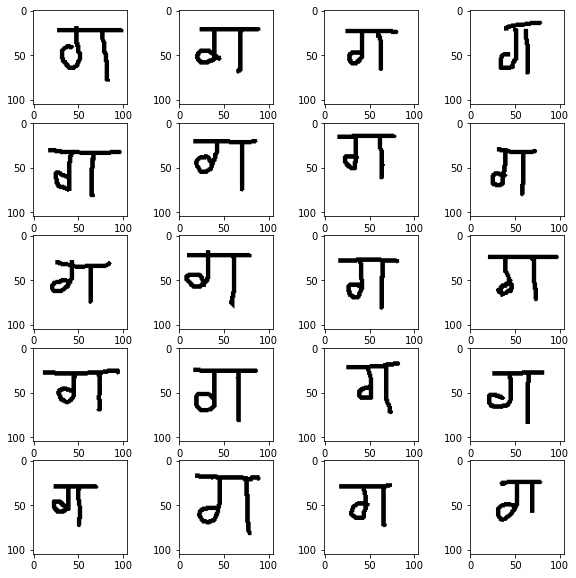

In [ ]:
plot_images('images_background/Sanskrit/character03/')

### Preparing batches and model

In [17]:
def get_batch(batch_size, s='train'):
    if s == 'train':
        X = Xtrain
    else:
        X = Xtest
    n_classes, n_examples, h, w = X.shape
    rng = np.random.default_rng()
    categories = rng.choice(n_classes, batch_size, replace=False) ### selecting from output classes ###

    pairs = [np.zeros((batch_size, h, w, 1)) for i in range(2)]

    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1 
    
    for i in range(batch_size):
        category = categories[i]
        idx1 = rng.integers(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx1].reshape(w,h,1)
        idx2 = rng.integers(0, n_examples)
        
        if i > batch_size//2:
            category2 = category
        else:
            category2 = (category + rng.integers(1, n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category2, idx2].reshape(w,h,1)
        
    return pairs, targets
        

In [18]:
def generator(batch_size, s='train'):
    while True:
        pairs, targets = get_batch(batch_size, s)
        yield(pairs, targets)

In [19]:
def initialize_weights(shape, name=None, **kwargs):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)


def initialize_bias(shape, name=None, **kwargs):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [20]:
def get_model(input_shape):
    
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    model = Sequential()
    
    model.add(Conv2D(64, (10, 10), activation='relu', input_shape = input_shape,  ### First Layer ###
                     kernel_initializer = initialize_weights,
                     kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(128, (7,7), activation='relu',                              ### Second Layer ###
                    kernel_initializer = initialize_weights,
                    bias_initializer = initialize_bias, 
                    kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(128, (4,4), activation='relu',                             ### third Layer ###
                    kernel_initializer = initialize_weights,
                    bias_initializer = initialize_bias, 
                    kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(256, (4,4), activation='relu',                            ### fourth Layer ###
                    kernel_initializer = initialize_weights,
                    bias_initializer = initialize_bias, 
                    kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096,
              activation='sigmoid',
              kernel_initializer = initialize_weights,
              bias_initializer = initialize_bias, 
              kernel_regularizer=l2(1e-3)))
    
    encodedl = model(left_input)
    encodedr = model(right_input)
    
    ### Customized layer for getting the difference between two encodings ###
    L1Layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1Distance = L1Layer([encodedl, encodedr])
    
    ### Final Layer ###
    prediction = Dense(1, activation='sigmoid', bias_initializer = initialize_bias)(L1Distance)
    
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
    print(siamese_net.summary())
    
    return siamese_net

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         38947648    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[0][0]         

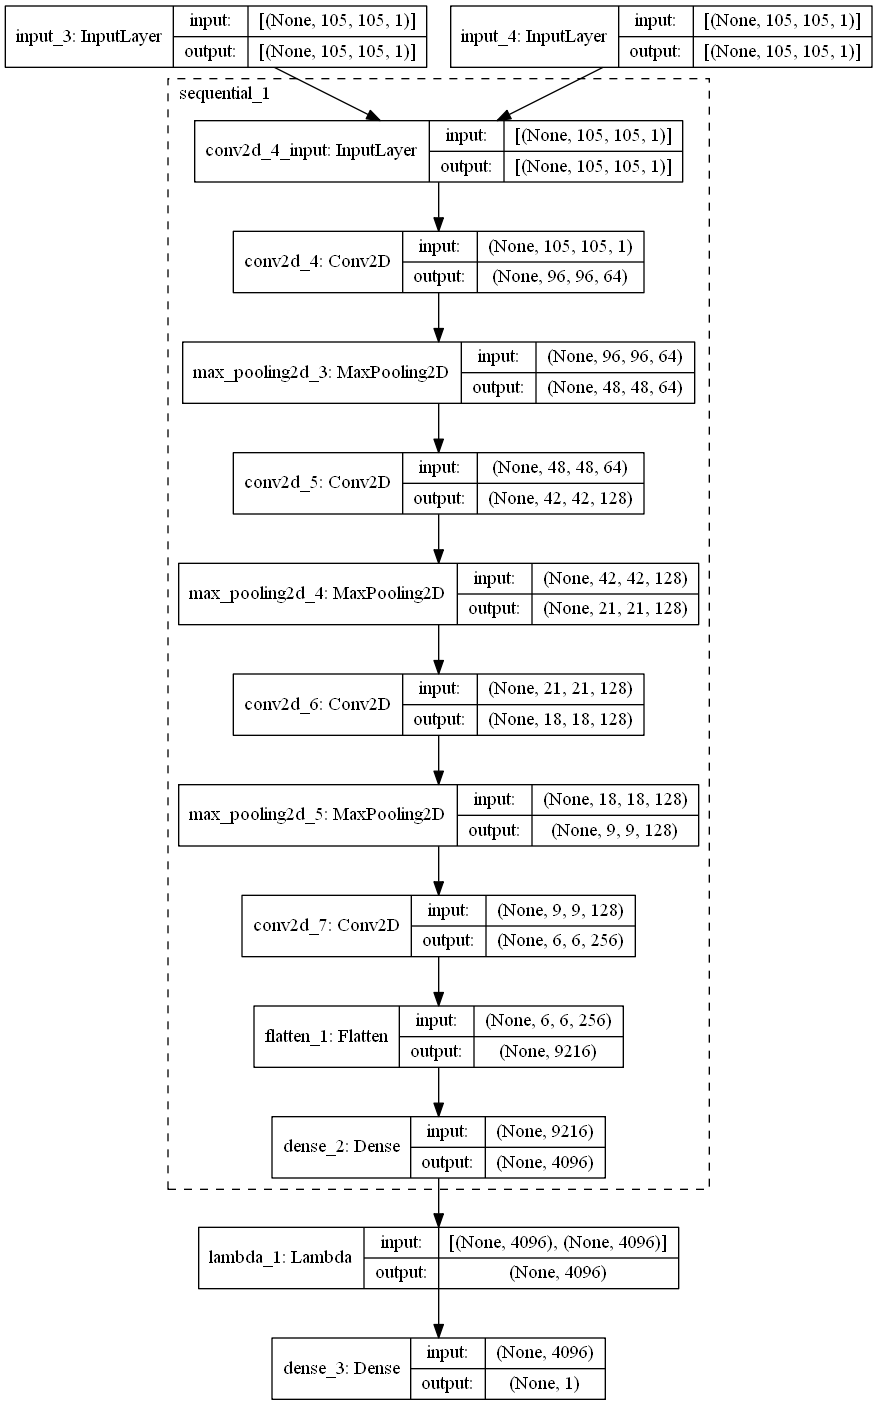

In [25]:
model = get_model((105,105,1))
plot_model(model, show_shapes=True, expand_nested=True)

In [26]:
model.load_weights('model_weights.h5')
optimizer = Adam(learning_rate=0.00006)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

### One-shot Task

In [33]:
def make_one_shot_task(N, s='val', language=None):
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xtest
        categories = val_classes

    n_classes, n_examples, w, h = X.shape
    
    rng = np.random.default_rng()
    if language is not None:
        high, low = categories[language]
        if N > high-low:
            raise ValueError(language, 'has less than {} letters'.format(N))
        categories = rng.choice(range(low, high), (N,), replace=False) ### Select N chars ###
    else:
        categories = rng.choice(range(n_classes), (N,), replace=False)
    
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples, (2, ), replace=False) 
    indices = np.random.randint(0, n_examples, size=(N,))    ### Select N images ###
    test_image_set = np.array([X[true_category,ex1,:,:]]*N).reshape(N,w,h,1)
    support_set = X[categories,indices,:,:] ### Select N images one from each previously chosen N char ###
    support_set[0,:,:] = X[true_category, ex2]
    support_set.reshape(N,w,h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image_set, support_set = shuffle(targets, test_image_set, support_set)
    pairs = [test_image_set, support_set]
    return pairs, targets


def nearest_neighbour_correct(pairs, targets):
    L2distance = np.zeros_like(targets)
    for i in range(len(targets)):
        L2distance[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))  ### this can be changed ###
    if np.argmin(L2distance) == np.argmax(targets):
        return 1
    else:
        return 0


def test_oneshot(model, N, k, s='val', verbose=0, model_type='siamese'):
    n_correct = 0
    if verbose:
        print('{} random {} way one-shot learning'.format(k,N))
    for i in range(k):
        inputs, target = make_one_shot_task(N, s)
        if model_type == 'siamese':
            prob = model.predict(inputs)
            if np.argmax(prob) == np.argmax(target):
                n_correct += 1
        else:
            n_correct += nearest_neighbour_correct(inputs, target)
    percent_correct = (n_correct * 100) / k
    if verbose:
        if model_type=='siamese':
            print('evaluation for siamese')
        else:
            print('evaluation for nearest neighbour')
        print('{}% correct for {}-way shot learning'.format(percent_correct,N))

    return percent_correct    

In [31]:
data_path = 'data'
with open("data/train.pickle", "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)

with open("data/val.pickle", "rb") as f:
    (Xtest, val_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(train_classes.keys()))
print("\n\nValidation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Training alphabets: 

['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh']


Validation alphabets:

['Angelic', 'Atemayar_Qelisayer', 'Atlantean', 'Aurek-Besh', 'Avesta', 'Ge_ez', 'Glagolitic', 'Gurmukhi', 'Kannada', 'Keble', 'Malayalam', 'Manipuri', 'Mongolian', 'Old_Church_Slavonic_(Cyrillic)', 'Oriya', 'Sylheti', 'Syriac_(Serto)', 'Tengwar', 'Tibetan', 'ULOG']


In [32]:
Xtrain.shape

(964, 20, 105, 105)

### Training Pipeline

In [ ]:
### Training code ###
N_ways = 20
epochs = 20000

trials = 250
batch_size = 32
loss_every = 20
evaluate_every = 10
start_time = time.time()
best = -1
for i in range(1, epochs):
    inputs, targets = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    print('\n','-'*20)
    print('Loss {}'.format(loss))
    if i % evaluate_every == 0:
        t = time.time() - start_time
        print('Time for {} iterations: {:.2f} seconds'.format(i, t))
        val_acc = test_oneshot(model, N_ways, trials, s='train', verbose=True)
        if val_acc >= best:
            print('Current best:{} and previous best:{}'.format(val_acc, best))
            best = val_acc
    if i % loss_every == 0:
        print('Loss for {} iteration is {:.2f}'.format(i, loss))

model.save_weights('data/model_weights_updates.h5')

### Testing Pipeline

450 random 1 way one-shot learning
evaluation for siamese
100.0% correct for 1-way shot learning
450 random 1 way one-shot learning
evaluation for siamese
100.0% correct for 1-way shot learning
450 random 1 way one-shot learning


C:\Users\anura\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


evaluation for nearest neighbour
100.0% correct for 1-way shot learning
450 random 3 way one-shot learning
evaluation for siamese
95.33333333333333% correct for 3-way shot learning
450 random 3 way one-shot learning
evaluation for siamese
96.66666666666667% correct for 3-way shot learning
450 random 3 way one-shot learning
evaluation for nearest neighbour
35.77777777777778% correct for 3-way shot learning
450 random 5 way one-shot learning
evaluation for siamese
88.0% correct for 5-way shot learning
450 random 5 way one-shot learning
evaluation for siamese
98.22222222222223% correct for 5-way shot learning
450 random 5 way one-shot learning
evaluation for nearest neighbour
16.0% correct for 5-way shot learning
450 random 7 way one-shot learning
evaluation for siamese
87.77777777777777% correct for 7-way shot learning
450 random 7 way one-shot learning
evaluation for siamese
93.77777777777777% correct for 7-way shot learning
450 random 7 way one-shot learning
evaluation for nearest neig

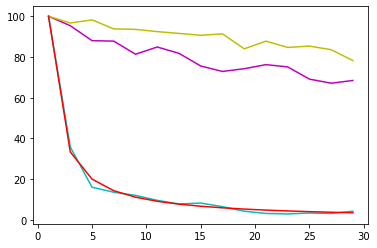

In [34]:
ways = np.arange(1, 30, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(test_oneshot(model, N,trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N,trials, "train", verbose=True))
    nn_accs.append(test_oneshot(model, N,trials, model_type='nn', verbose=True))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()

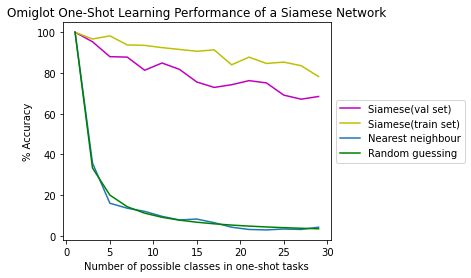

In [35]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = make_one_shot_task(20, "val")
plt.show()

### Inference and Observations
The above model created seems to overfit a bit, one of the main reasons can be, the learning decay for each layer(as it is being mentioned in the original paper), has not been implemented in the current notebook.

Also one of the other reasons can be, is number of iterations during training time. Currently the model is being trained for 20,0000 iterations, one iteration being one full pass over the data set.

Metric used to test the efficiency of the model Siamese Networks are mainly used to Image Verification.

Image Verification, being the task you're given two images and you have to tell if they are of the same person/class or category. Since in context of the problem we have in hand of image verification, classifying similar images of characters as same is the main problem we need to solve, therefore choosing accuracy is the right metric we should use to validate the performance of our model on new unseen data.